### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут

1) $L(F(x_i),y_i)=(y_i-F(x_i))^2$

grad=$\frac{dL}{dF}=-2(y_i-F(x_i))=2(F(x_i)-y_i)$

new_target=-grad=$-2(F(x_i)-y_i)$

2) $L(F(x_i), y_i) = exp( -F(x_i) y_i)$

grad=$\frac{dL}{dF}=-y_i*exp( -F(x_i) y_i)$

new_target=-grad=y_i*exp( -F(x_i) y_i)

3) $L(F(x_i), y_i) = \log (1 + exp( -F(x_i) y_i))$

grad=$\frac{dL}{dF}=-y_i*exp( -F(x_i) y_i)/(1 + exp( -F(x_i) y_i))$

new_target=-grad=$y_i*exp( -F(x_i) y_i)/(1 + exp( -F(x_i) y_i))$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [174]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tqdm import tqdm

In [184]:
class MyGradientBoostingClassifier:

    def __init__(self, loss_type="mse", learning_rate=0.01, n_estimators=100, dola_priznakov=1, dola_objects=1, *args, **kwargs):
        """
        loss_type -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        dola_priznakov -- процент рандомных признаков при обучнеии одного алгоритма
        dola_objects -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        self.loss_type=loss_type
        self.learning_rate=learning_rate
        self.n_estimators=n_estimators
        self.dola_priznakov=dola_priznakov
        self.dola_objects=dola_objects
        self.args=args
        self.kwargs=kwargs
        self.mas_fs=[]
        self.mas_feature_perm=[]
        self.init_model=None
        
    def F(self,X):
        #print("Hello from F")
        N=len(X)
        otv=np.zeros(N) #vector
        start=0
        if self.init_model is None:
            #print("Hello from h1")
            otv=self.mas_fs[0]*np.ones(N) #vector
            start=1
        
        for model,prizn_permut in zip(self.mas_fs[start:],self.mas_feature_perm[start:]):
            otv+=self.learning_rate*model.predict(X[:,prizn_permut]) #vector
        
        return np.array(list(map(int,otv)))
    
    def calc_grad(self,X,y):
        N=len(y)
        otv=np.zeros(N)
        if self.loss_type=="mse":
            otv=2*(self.F(X)-y) #vector
        elif self.loss_type=="exp":
            otv=-y*np.exp(-self.F(X)*y) #vector
        elif self.loss_type=="log":
            otv=(-y*np.exp(-y * self.F(X))) / (1 + np.exp(self.F(X) * y)) #vector
        return otv
        
        
            
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        # Ваш код здесь
        self.mas_fs=[]
        self.mas_feature_perm=[]
        self.init_model=init_model
        
        priznak_size = int(X.shape[1] * self.dola_priznakov)
        objects_size = int(X.shape[0] * self.dola_objects)
        

        
        if (init_model is not None):
            f0=init_model

            
            priznaki_permut = np.arange(X.shape[1])[0:priznak_size]
            objects_permut = np.arange(X.shape[0])[0:objects_size]
            
            f0.fit(X[objects_permut,:][:,priznaki_permut], y[objects_permut])
            self.mas_fs.append(f0)
            self.mas_feature_perm.append(priznaki_permut)
            
        else:
            self.mas_fs.append(np.bincount(y).argmax())
            self.mas_feature_perm.append(np.arange(X.shape[1]))
        
        for k in range(1,self.n_estimators+1):
            priznaki_permut = np.arange(X.shape[1])[0:priznak_size]
            objects_permut = np.arange(X.shape[0])[0:objects_size]
            
            new_target=-self.calc_grad(X[objects_permut,:][:,priznaki_permut], y[objects_permut])
            #print("new_target",new_target)
            fk=base_model(*self.args, **self.kwargs)
            fk.fit(X[objects_permut,:][:,priznaki_permut], new_target[objects_permut])
            self.mas_fs.append(fk)
            self.mas_feature_perm.append(priznaki_permut)
            
        
    def predict(self, X):
        # Ваш код здесь
        #print("Hello from predict")
        return self.F(X)

In [185]:
my_clf = MyGradientBoostingClassifier(n_estimators=100)
clf = GradientBoostingClassifier()

In [186]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [178]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовать
разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [179]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [180]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [181]:
mas_x = []
mas_y = []
for i in tqdm(range(5,100)):
    mas_x.append(i)
    my_clf = MyGradientBoostingClassifier(n_estimators = i, max_depth = 5)
    accuracy = 0
    for j in range(3):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
        my_clf.fit(X_train, y_train)
        accuracy += accuracy_score(my_clf.predict(X_test), y_test)
    mas_y.append(accuracy / 3)

100%|██████████| 95/95 [24:01<00:00, 30.34s/it]


optimal estimator 99
best accuracy 0.8195251937984497


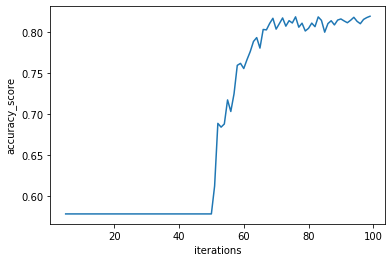

In [182]:
plt.xlabel("iterations")
plt.ylabel("accuracy_score")
plt.plot(mas_x,mas_y)
print('optimal estimator', mas_x[np.argmax(mas_y)])
print('best accuracy', np.max(mas_y))

In [189]:
kf = KFold(n_splits = 5)
accuracy_mas = []
for loss in tqdm(['mse', 'exp', 'log']):
    my_clf = MyGradientBoostingClassifier(loss_type = loss, n_estimators = 100, max_depth = 5)
    accuracy = 0
    for train_index, test_index in kf.split(X):
        my_clf.fit(X[train_index], y[train_index])
        accuracy += accuracy_score(my_clf.predict(X[test_index]), y[test_index])
    accuracy_mas.append(accuracy / 5)

100%|██████████| 3/3 [02:32<00:00, 50.64s/it]


In [190]:
print(accuracy_mas)

[0.7835271317829458, 0.5779554263565891, 0.5780523255813954]


In [197]:
accuracy_mas = []
for step in tqdm([0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]):
    my_clf = MyGradientBoostingClassifier(learning_rate = step, n_estimators = 100, max_depth = 5)
    accuracy = 0
    for train_index, test_index in kf.split(X):
        my_clf.fit(X[train_index], y[train_index])
        accuracy += accuracy_score(my_clf.predict(X[test_index]), y[test_index])
    accuracy_mas.append(accuracy / 5)


100%|██████████| 7/7 [06:25<00:00, 53.97s/it]

optimal learning_rate 0.01


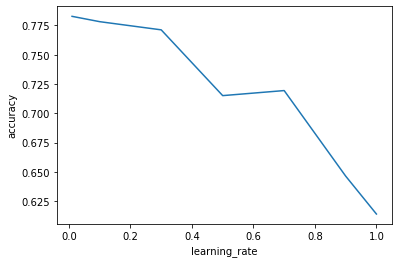

In [196]:
plt.xlabel('learning_rate')
plt.ylabel('accuracy')
plt.plot([0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1], accuracy_mas)
print('optimal learning_rate', [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1][np.argmax(accuracy_mas)])


Depth: 3 accuracy: 0.91875
Depth: 5 accuracy: 0.93125
Depth: 7 accuracy: 0.9125
Depth: 10 accuracy: 0.91875
Depth: 20 accuracy: 0.9125
Depth: 30 accuracy: 0.9125
Depth: 40 accuracy: 0.9
Depth: 50 accuracy: 0.94375


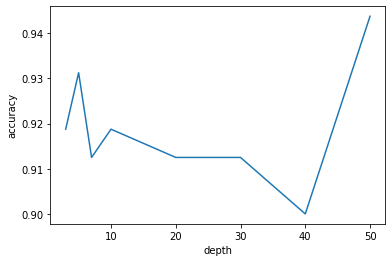

In [203]:
depth = [3, 5, 7, 10, 20, 30, 40, 50]

def find_best_max_depth(depth):
    accuracy = []
    for max_depth in depth:
        kf = KFold(n_splits=5)
        scores = []
        for train_index, val_index in kf.split(X_train):
            my_clf = MyGradientBoostingClassifier(loss_type='mse', learning_rate=0.01,\
                                                  n_estimators=100, max_depth=max_depth)
            data_train, data_val = X_train[train_index], X_train[val_index]
            target_train, target_val = y_train[train_index], y_train[val_index]
            my_clf.fit(data_train, target_train, DecisionTreeRegressor)
            prediction = my_clf.predict(data_val)
            score = accuracy_score(target_val, prediction)
            scores.append(score)
        scores = np.mean(scores)
        accuracy.append(scores)
        print(f"Depth: {max_depth} accuracy: {scores}")
    return accuracy
accuracy = find_best_max_depth(depth)

plt.xlabel('depth')
plt.ylabel('accuracy')
plt.plot(depth, accuracy)

In [ ]:
В итоге n_estimators=100,loss_type='mse',learning_rate=0.01, depth=50

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [206]:
import warnings
warnings.filterwarnings('ignore')

In [207]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
my_clf = MyGradientBoostingClassifier(learning_rate=0.01, n_estimators=100, max_depth = 5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
my_clf.fit(X_train, y_train, base_model=RandomForestRegressor)
accuracy_score(my_clf.predict(X_test), y_test)

0.8294573643410853

In [ ]:
Качетство чуть-чуть приросло

In [ ]:
Теперь 100 бустингов

In [209]:
mas = np.ones(X_test.shape[0])
for i in tqdm(range(100)):
    samples = np.random.randint(0, X_train.shape[0], size = X_train.shape[0])
    my_clf = MyGradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, max_depth = 5)
    my_clf.fit(X_train, y_train)
    mas += my_clf.predict(X_test)
print(accuracy_score(np.round(mas / 100), y_test))



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:11<19:43, 11.96s/it]

  2%|▏         | 2/100 [00:24<19:54, 12.19s/it]

  3%|▎         | 3/100 [00:35<18:56, 11.71s/it]

  4%|▍         | 4/100 [00:45<18:12, 11.38s/it]

  5%|▌         | 5/100 [00:56<17:41, 11.18s/it]

  6%|▌         | 6/100 [01:07<17:33, 11.21s/it]

  7%|▋         | 7/100 [01:18<17:19, 11.18s/it]

  8%|▊         | 8/100 [01:29<16:47, 10.95s/it]

  9%|▉         | 9/100 [01:43<17:55, 11.82s/it]

 10%|█         | 10/100 [01:55<17:53, 11.92s/it]

 11%|█         | 11/100 [02:06<17:18, 11.67s/it]

 12%|█▏        | 12/100 [02:17<16:37, 11.34s/it]

 13%|█▎        | 13/100 [02:27<16:12, 11.17s/it]

 14%|█▍        | 14/100 [02:38<15:56, 11.12s/it]

 15%|█▌        | 15/100 [02:49<15:37, 11.02s/it]

 16%|█▌        | 16/100 [03:01<15:39, 11.18s/it]

 17%|█▋        | 17/100 [03:12<15:22, 11.11s/it]

 18%|█▊        | 18/100 [03:22<15:01, 11.00s/it]

 19%|█▉        | 19/100 [03:34<14:57, 11.08s/it]

 20%|██        |

0.8662790697674418


In [ ]:
Качество очень даже приросло, потому что случайный лес сильнее одного дерева

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [210]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [218]:
my_clf = MyGradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, max_depth = 5)
my_clf.fit(X_train, y_train, init_model = LinearRegression())
accuracy_score(my_clf.predict(X_test), y_test)

0.8500484496124031

In [213]:
my_clf = MyGradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, max_depth = 5)
my_clf.fit(X_train, y_train, init_model = RandomForestRegressor())
accuracy_score(my_clf.predict(X_test), y_test)

0.8527131782945736

In [215]:
my_clf = MyGradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100,max_depth = 5)
my_clf.fit(X_train, y_train, init_model = SVR())
accuracy_score(my_clf.predict(X_test), y_test)

0.8035368217054264

In [ ]:
Вывод: svm очень долго работает, но скор у него меньше, чем у 
RandomForestRegressor() и LinearRegression()

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

